# Correlation Visualization JND Example Study

In this example, we'll create a full two-alternative forced choice (2AFC) study for visualizations of correlated data (from [1]), using vega components. We'll use numpy and scipy to generate a dataset, pandas to create a well-structured data frame, and the `revisitpy` package to tie it all together.

You'll see that we have a section which uses the `revisitpy` Widget. This widget is a fully interactive jupyter notebook widget which allows us to preview the created study directly in the notebook. You'll notice that we also utilize the `revisitpy_server` package. This is to simplify the process of viewing our widget. Specifically, it removes the requirement of having a version of the reVISit repository running locally on your computer.

[1] Harrison, Lane, Fumeng Yang, Steven Franconeri, and Remco Chang. "Ranking visualizations of correlation using weber's law." IEEE transactions on visualization and computer graphics 20, no. 12 (2014): 1943-1952.

We'll start by defining the basic structure of the study:

In [1]:

import revisitpy as rvt

# Meta Data
study_metadata = rvt.studyMetadata(
    authors=["Brian Bollen"],
    organizations=["Visualization Design Lab"],
    title='Correlation Judgment Study',
    description='',
    date='2025-01-13',
    version='1.0'
)


# UI Config
ui_config = rvt.uiConfig(
  contactEmail="briancbollen@gmail.com",
  logoPath="./assets/revisitLogoSquare.svg",
  sidebar=True,
  withProgressBar=False,
  nextOnEnter=True
)

# Introduction
introduction = rvt.component(type='markdown', path='./assets/introduction.md', component_name__= 'introduction')

# Snippet of the introduction component.
print(introduction)


{
    "path": "./assets/introduction.md",
    "response": [],
    "type": "markdown"
}


## Generating Correlation Data

We now want to generate the datasets that will go into our vega charts. We don't yet have to worry about rendering these, we'll just define the functions to generate the data.

In [2]:
import numpy as np
from scipy.special import erfinv, erf

def generate_correlated_data_uniform(correlation, num_points, seed=None):
    """
    Generate a dataset with two variables having the specified correlation,
    with values bounded between 0 and 1.
    Parameters:
        correlation (float): Desired correlation coefficient (-1 to 1).
        num_points (int): Number of data points to generate.
        seed (int, optional): Random seed for reproducibility.
    Returns:
        np.ndarray: A 2D array of shape (num_points, 2), where each column is a variable.
    """
    if not -1 <= correlation <= 1:
        raise ValueError("Correlation must be between -1 and 1.")
    if seed is not None:
        np.random.seed(seed)
    # Generate two independent uniform random variables between 0 and 1
    x = np.random.rand(num_points)
    z = np.random.rand(num_points)
    # Apply inverse transform sampling to convert uniform to normal
    x_normal = np.sqrt(2) * erfinv(2 * x - 1)  # Inverse CDF of normal distribution
    z_normal = np.sqrt(2) * erfinv(2 * z - 1)
    # Combine them using the desired correlation
    y_normal = correlation * x_normal + np.sqrt(1 - correlation**2) * z_normal
    # Transform back to uniform distribution using normal CDF
    x_uniform = 0.5 * (1 + erf(x_normal / np.sqrt(2)))
    y_uniform = 0.5 * (1 + erf(y_normal / np.sqrt(2)))
    # Stack into a 2D array
    data = np.column_stack((x_uniform, y_uniform))
    return data

# Example of dataset
print(generate_correlated_data_uniform(0.6, 10, seed=42))

[[0.37454012 0.03397256]
 [0.95071431 0.99369625]
 [0.73199394 0.87335673]
 [0.59865848 0.31251313]
 [0.15601864 0.09121347]
 [0.15599452 0.09198872]
 [0.05808361 0.08811887]
 [0.86617615 0.76262552]
 [0.60111501 0.50662253]
 [0.70807258 0.45573666]]


# Vega ScatterPlots and Parallel Coordinate Plots

For this study, we need to generate pairs of scatterplots and pairs of parallel coordinate plots. We will create two generalized functions which take in two data frames whose columns are 'X' and 'Y' and whose entries are tuples, indicating the coordinates. These functions will each return a vega-altair chart that will be added as components.

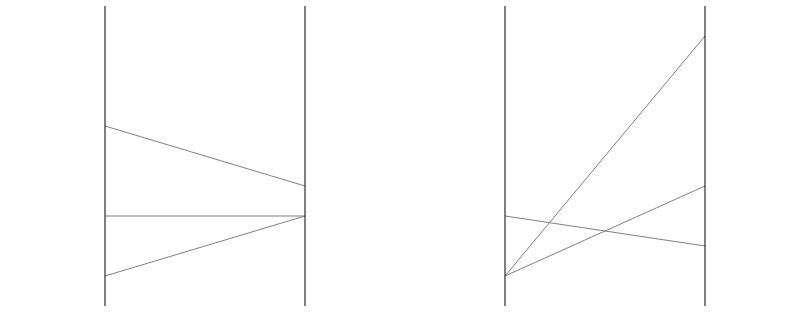

In [3]:
import pandas as pd
import altair as alt

# Enable png output to save the image.
alt.renderers.enable("png")

def create_parallel_plot(data1, data2):
    data1_melted = data1.reset_index().melt(id_vars='index', var_name='Axis', value_name='Value')
    data2_melted = data2.reset_index().melt(id_vars='index', var_name='Axis', value_name='Value')
    
    # Create the parallel coordinates chart
    parallel1 = alt.Chart(data1_melted).mark_line(stroke='grey', strokeWidth=1).encode(
        x=alt.X('Axis:O', axis=alt.Axis(labels=False, ticks=False, grid=False, domain=False, title=None, labelPadding=0)),
        y=alt.Y('Value:Q', axis=alt.Axis(labels=False, ticks=False, grid=False, domain=False, title=None)),  # Values on the vertical axis
        detail='index:N',  # Ensure each line corresponds to a single data row
    ).properties(
        title="", width=400, height=300
    )
    
    parallel2 = alt.Chart(data2_melted).mark_line(stroke='grey', strokeWidth=1).encode(
        x=alt.X('Axis:O', axis=alt.Axis(labels=False, ticks=False, grid=False, domain=False, title=None,)),
        y=alt.Y('Value:Q', axis=alt.Axis(labels=False, ticks=False, grid=False, domain=False, title=None)),  # Values on the vertical axis
        detail='index:N',  # Ensure each line corresponds to a single data row
    ).properties(
        title="", width=400, height=300
    )
    
    axis_lines = alt.Chart(pd.DataFrame(
        {'Axis': ['X', 'Y'], 'y_start': [0, 0], 'y_end': [1, 1]}
    )).mark_rule(stroke='black', strokeWidth=1).encode(
        x=alt.X('Axis:O'), y=alt.Y('y_start:Q'), y2='y_end:Q'
    )
    
    parallel1 = parallel1 + axis_lines
    parallel2 = parallel2 + axis_lines
    
    chart = alt.hconcat(
        parallel1, parallel2
    ).configure_view(
        strokeWidth=0, continuousWidth=400, continuousHeight=300, step=50
    ).configure_concat(spacing=0)
    
    return chart
    
def create_scatter_plot(data1, data2):
    # Create Scatter plot 1
    scatter1 = alt.Chart(data1).mark_point(fill='black', stroke='black').encode(
        x=alt.X('X:Q', axis=alt.Axis( labels=False, ticks=False, grid=False, domain=True, title=None)),
        y=alt.Y('Y:Q', axis=alt.Axis( labels=False, ticks=False, grid=False, domain=True, title=None))
    ).properties(
        title='', width=300, height=300
    )
    
    # Create Scatter plot two
    scatter2 = alt.Chart(data2).mark_point(fill='black', stroke='black').encode(
        x=alt.X('X:Q', axis=alt.Axis( labels=False, ticks=False, grid=False, domain=True, title=None)),
        y=alt.Y('Y:Q', axis=alt.Axis( labels=False, ticks=False, grid=False, domain=True, title=None))
    ).properties(
        title='', width=300, height=300
    )
    
    chart = alt.hconcat(
        scatter1, scatter2
    ).configure_view(
        strokeWidth=0, continuousWidth=300, continuousHeight=300, step=10               
    ).configure_concat(
        spacing=100,
    )
    
    return chart

# Make some fake test data
test_data_1 = pd.DataFrame({'X':[0.1,0.3,0.6], 'Y':[0.3,0.3,0.4]})
test_data_2 = pd.DataFrame({'X':[0.1,0.1,0.3], 'Y':[0.4,0.9,0.2]})

# Display chart
# chart = create_scatter_plot(test_data_1,test_data_2)
chart = create_parallel_plot(test_data_1,test_data_2)
chart

# Generate Vega Spec to combine Generated Data and Plots

Now that we have our functions to create the individual chart, we want a function that returns the correct vega spec when given the number of points, the correlation values, and the visualization type ('scatterPlot' or 'parallelPlot'). We'll use the number of points and the pair of correlation values to generate the dataset. Using the visualization type, we'll either return the scatter plot of this data or the parallel coordinates plot. Hover, instead of returning the vega-altair chart, we instead convert the chart to its vega-lite specification, then convert that into the true vega specification.


In [4]:
import random
import pandas as pd
import altair as alt
import vl_convert as vlc



def create_vega_chart(visType, numPoints, corrValues):
    random.shuffle(corrValues)
    # Convert NumPy array to a DataFrame
    data1 = pd.DataFrame(
        generate_correlated_data_uniform(corrValues[0], numPoints, seed=42),
        columns=['X', 'Y']
    )
    data2 = pd.DataFrame(
        generate_correlated_data_uniform(corrValues[1], numPoints, seed=42),
        columns=['X', 'Y']
    )
    

    if visType == 'scatterPlot':
        chart = create_scatter_plot(data1, data2)
    else:
        chart = create_parallel_plot(data1, data2)

    vega_lite_spec = chart.to_json()
    vega_spec = vlc.vegalite_to_vega(vega_lite_spec, vl_version="5.20")
    return vega_spec
    

my_vega_spec = create_vega_chart('parallelPlot', 20, [0.3,0.9])

# We can print the test vega specification above to inspect its contents.

# print(my_vega_spec)


# Creating The Component Function & Interaction Signals for ReVISit Trials

The `component_function` is used to transform every component in a given sequence to any new component. If we have a sequence that is the correct _structure_, then we call the `component()` method on that sequence and pass in the desired `component_function`. Any `meta` attributes in the original components are passed in as arguments to the `component_function`. 

We'll create a component function which takes in the visualization type, the correlation values, and the number of points and returns the correct vega specification component. Additionally, we append signals directly into the vega spec so that we can detect the user's right and left arrow keys. Instead of the user having to choose "left" or "right" in some drop down, the user will be able to use the left and right arrow keys to pick the chart. We add an additional signal to "highlight" the selected chart with a thick blue border. Finally, since we specified "nextOnEnter" as "True" in the "uiConfig", the user will also be able to proceed to the next component by pressing the "Enter" key. All of this combined creates a seamless study experience.

In [5]:
def component_function(visType=None, numPoints=None, corrValues=None):
    if(visType is not None and numPoints is not None and corrValues is not None):
        vega_spec = create_vega_chart(visType=visType, numPoints=numPoints, corrValues=corrValues)
            
        # Update signals with new signals for the final vega spec.
        vega_spec['config']["signals"] = [
            {
                "name": "revisitAnswer",
                "value": {},
                "on": [
                    {
                        "events": "@concat_0_group:click",
                        "update": "{responseId: 'vegaDemoResponse1', response: 'left'}"
                    },
                    {
                        "events": "@concat_1_group:click",
                        "update": "{responseId: 'vegaDemoResponse1', response: 'right'}"
                    },
                    {
                        "events": {"source": "window", "type": "keydown"},
                        "update": "event.key === 'ArrowLeft' ? {responseId: 'vegaDemoResponse1', response: 'left'} : event.key === 'ArrowRight' ? {responseId: 'vegaDemoResponse1', response: 'right'} : revisitAnswer"
                    },
                ]
            }
        ]
        
        # Add signal based bordering
        for entry in vega_spec['marks']:
            if entry['name'] == 'concat_0_group':
                condition = 'left'
            else:
                condition = 'right'
            entry['encode']['update']['stroke'] = {
                "signal": f"revisitAnswer.response === '{condition}' ? 'blue' : null"
            },
            entry['encode']['update']['strokeWidth'] = {
                "signal": f"revisitAnswer.response === '{condition}' ? 3 : 0"
            }
        
        return rvt.component(
            type='vega',
            config=vega_spec,
            component_name__=f'{visType}-{numPoints}-{round(corrValues[0],1)},{round(corrValues[1],1)}',
            response=[
                rvt.response(
                    id='vegaDemoResponse1',
                    prompt='You Selected: ',
                    location='sidebar',
                    type='reactive',
                    required=True
                )
            ]
        )

    return rvt.component(
        type='questionnaire',
        component_name__='blank-component'
    )

# You can print the output of our component function with some test values.

# print(component_function('scatterPlot',20,corrValues=[0.2,0.9]))

# Permuting the Final Sequence 

Here we generate the different combinations of the correlation values that we'd like (every combination of two numbers between 0 and 1 with precision 1). Then, we generate a fixed order sequence and being the permutations over our factors. We first permute over the visualization type, then over the number of points, then over all possible correlation value pairs.

When we permute over these factors, the corresponding factored will be added to the `meta` attributes of each component. By the end of these three permutations, we will have components that have 'visType', 'numPoints', and 'corrValues' key-value pairs in their `meta` attribute. Before calling the `component` method, these are all "filler" or "placeholder" components with no real value aside from their metadata attributes. Once we call the `component` method, each component is passed through the inputted `component_function` which will take the existing metadata as arguments. Thus, by the end of this method chaining, each component will be the correct vega component.

After we have finished generating the sequence, we add the entire component block to an a sequence only containing the introduction.

In [6]:
import itertools

# Generate all combinations of two values between 1 and 10
combinations = itertools.combinations(range(1, 11), 2)

# Create the dataset with values divided by 10
dataSet = [{'corrValues': [x / 10, y / 10]} for x, y in combinations]
# Create the dataset with values divided by 10


main_sequence = rvt.sequence(order='fixed')

main_sequence.permute(
        factors=[{'visType': 'scatterPlot'}, {'visType': 'parallelCoords'}],
        order='latinSquare',
    ).permute(
        factors=[{'numPoints': 20}, {'numPoints': 100}],
        order='fixed',
    ).permute(
        factors=dataSet,
        order='random',
    ).component(component_function)
    
sequence = rvt.sequence(order='fixed',components=[introduction]) + main_sequence

study = rvt.studyConfig(
    schema="https://raw.githubusercontent.com/revisit-studies/study/v2.0.0-rc1/src/parser/StudyConfigSchema.json",
    uiConfig=ui_config,
    studyMetadata=study_metadata,
    sequence=sequence
)

# Prints the entire configuration file which is approximately 150,000 lines of JSON
# print(study)


# Using `revisitpy_server` to Prepare Our Widget

The `revisitpy` package provides a widget in order to preview our study directly in a Jupyter notebook. We can interact with the study, check that vega signals work, and even create some introductory data ourselves. In order for the widget to work, a local copy of the reVISit must be running on your local computer. If you already have reVISit locally (colloqioully our `study` repo), then all you need to do is navigate to your repository and run `yarn serve`. After this, the widget we create in this jupyter notebook will be useable.

A simpler way to achieve the same goal, however is using the `revisitpy_server` Python package. This is a simple python package which already has the most recent reVISit repository built and runs a server locally. After installing `revisitpy_server`, all that is required is the following:

In [7]:
import revisitpy_server as rs
process = rs.serve()

Server is running in the background at http://localhost:8080


# The Widget

Now that your server is running, we create the widget with the configuration file we created above. When calling the widget, we are assuming that the assets referenced in the configuration file are relative to this notebook. The widget then copies these static assets to the appropriate directory. Since we're currently using the `revisitpy_server` package, you'll see that they copied into the assets of the local virtual environment `revisitpy_server` package.

In [170]:
w = rvt.widget(study, server=True)

# In your own Jupyter notebook, calling `w` will now display the widget in a fully interactive manner.
# w

Copying file from ./assets/introduction.md to /Users/bbollen23/revisit-py-examples/.venv/lib/python3.12/site-packages/revisitpy_server/static/__revisit-widget/assets/introduction.md
Copying file from ./assets/revisitLogoSquare.svg to /Users/bbollen23/revisit-py-examples/.venv/lib/python3.12/site-packages/revisitpy_server/static/__revisit-widget/assets/revisitLogoSquare.svg


# Optional: Data Collection

Now that we have the widget running, we can check out some sample data that would be generated from a user. Start by going through a small portion of the study. Once you've gone through the desired number of components inside the widget, navigate to the analysis dashboard using the 'Analysis' tab in the upper left-hand corner. Here you'll see individual participants and the data that they've generated. 

From here, we can export this data back into our Jupyter notebook. Start by clicking the "Download as Tidy CSV" on the right-hand side above the table. Here you'll be shown a preview of the CSV file with some additional options to truncate the data. In the bottom right-hand corner, you'll see a button with the Python icon. Clicking on this button will send the Tidy CSV back to the Jupyter notebook. Once the button is clicked, we can preview the data like so:

In [ ]:
w.get_df()

# Optional: Terminate the server

Closing the notebook will automatically terminate the server. If you'd rather do this manually, you can do the following.

In [21]:
process.terminate()